# What are the main topics in NIPS 2015 papers?

My goal here is to identify main topics in NIPS papers published in 2015. For this purpose, I used [Latent Dirichlet allocation (LDA) algorithm](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). Before applying this I wanted to see the number of clusters in the entire text data. Let's get started!

In [22]:
import pandas as pd
import re
import gensim
import wordcloud
import matplotlib.pyplot as plt
import numpy as np
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, similarities
from collections import defaultdict
from sklearn.cluster import KMeans
import seaborn as sns
%pylab inline
from nltk.stem.snowball import SnowballStemmer

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Read Data

We need to clean the data a bit. We should remove characters as '\n', '\x0c'. I also use nltk's stemmer so that "algorithm" and "algorithms" are the same words for the training.

In [2]:
papers_data = pd.read_csv('output/Papers.csv')
stemmer = SnowballStemmer("english")
def clean_text(text):
    list_of_cleaning_signs = ['\x0c', '\n']
    for sign in list_of_cleaning_signs:
        text = text.replace(sign, ' ')
    clean_text = re.sub('[^a-zA-Z]+', ' ', text)
    text_stemmed = [stemmer.stem(word) for word in clean_text.split()]
    return ' '.join(text_stemmed)
papers_data['PaperText_clean'] = papers_data['PaperText'].apply(lambda x: clean_text(x))
papers_data.head(3)

,Id,Title,EventType,PdfName,Abstract,PaperText,PaperText_clean
0,5677,Double or Nothing: Multiplicative Incentive Me...,Poster,5677-double-or-nothing-multiplicative-incentiv...,Crowdsourcing has gained immense popularity in...,Double or Nothing: Multiplicative\nIncentive M...,doubl or noth multipl incent mechan for crowds...
1,5941,Learning with Symmetric Label Noise: The Impor...,Spotlight,5941-learning-with-symmetric-label-noise-the-i...,Convex potential minimisation is the de facto ...,Learning with Symmetric Label Noise: The\nImpo...,learn with symmetr label nois the import of be...
2,6019,Algorithmic Stability and Uniform Generalization,Poster,6019-algorithmic-stability-and-uniform-general...,One of the central questions in statistical le...,Algorithmic Stability and Uniform Generalizati...,algorithm stabil and uniform general ibrahim a...


# Create Dictionary and Corpus

Now we need to create dictionary and corpus for our learning. Note that the stopwords, single character are removed from dictionary and corpus. We also remove the words which occur only in one document.

In [3]:
dictionary = corpora.Dictionary(line.split() for line in papers_data['PaperText_clean'])
stop_ids_text = [dictionary.token2id[stopword] for stopword in STOPWORDS
            if stopword in dictionary.token2id]
once_ids_text = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq == 1]
single_char_text = [tokenid for tokenid, word in dictionary.items() if len(word) == 1]
dictionary.filter_tokens(stop_ids_text + once_ids_text + single_char_text) # remove stop words and words that appear only once
dictionary.compactify() # remove gaps in id sequence after words that were removed
print(dictionary)

Dictionary(12079 unique tokens: [u'orthogon', u'cussen', u'yellow', u'interchang', u'bshouti']...)


In [4]:
texts = [[word for word in document.split()  if (( word not in STOPWORDS) & (len(word)>1)) ]
          for document in papers_data['PaperText_clean']]
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token]+=1
texts = [[token for token in text if frequency[token] > 1]
         for text in texts]
corpus = [dictionary.doc2bow(text) for text in texts]

I was curious to see top 50 words across all texts.

(-0.5, 1399.5, 999.5, -0.5)

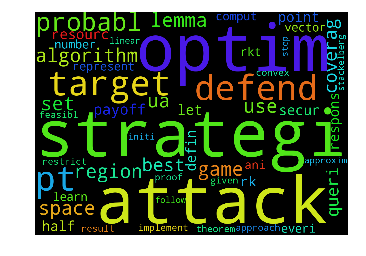

In [16]:
wc = wordcloud.WordCloud(background_color='black', max_words=50, width=1400, height=1000).generate(' '.join(text))
plt.imshow(wc) 
plt.axis("off")

# TF-IDF Transformation

We then transform the term frequency matrix into [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) domain so that the most frequent words in the corpus are penalized. 

In [17]:
tfidf = gensim.models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

# Latent Semantic Analysis

[Latent semantic analysis (LSA)](https://en.wikipedia.org/wiki/Latent_semantic_analysis) is a SVD based technique to reduce the dimension of the term-document matrix.

In [19]:
# project to 2 dimensions for visualization
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
corpus_lsi = lsi[corpus_tfidf]

Let's put the values in two dimension into a matrix.

In [20]:
X = []
for vector in corpus_lsi:
    try:
        X.append([vector[0][1], vector[1][1]])
    except:
        pass

# K-means clustering

We can apply K-means clustering in this 2 dimensional data space. In order to determine the best number of clusters we can plot the inertia which is defined as the sum of squared differences of each point to its cluster centroid. The code below runs the script from Salmon Run's [blog](http://sujitpal.blogspot.com/2014/08/topic-modeling-with-gensim-over-past.html).

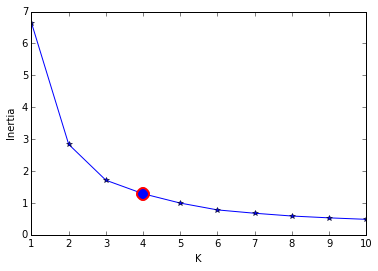

In [21]:
MAX_K = 10

ks = range(1, MAX_K + 1)

inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)
for k in ks:
    kmeans = KMeans(k).fit(X)
    inertias[k - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

elbow = np.argmin(diff3[3:]) + 3

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

Since the elbow point happens when K is 4, I will use 4 as the number of topics and clusters in the rest of this document. Let's visualize the clusters in 2D:

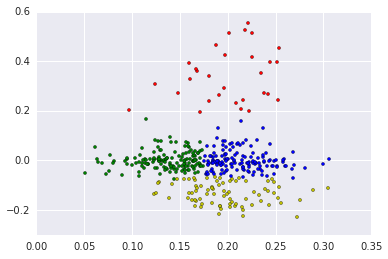

In [24]:
NUM_TOPICS = 4
kmeans = KMeans(NUM_TOPICS).fit(X)
y = kmeans.labels_

colors = ["b", "g", "r", "y"]
for i in range(np.shape(X)[0]):
    plt.scatter(X[i][0], X[i][1], c=colors[y[i]], s=10)    
plt.show()

Clusters actually look well-separated!

# Apply LDA

Each document can be viewed as combinations of several topics. I want to see what those topics are. [Latent Dirichlet allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) can be used for this purpose.

In [25]:
NUM_TOPICS = 4
lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS, iterations=1000, passes=10)
lda.print_topics(NUM_TOPICS)

[(0,
  u'0.025*model + 0.013*use + 0.009*learn + 0.008*train + 0.007*imag + 0.007*data + 0.007*network + 0.006*distribut + 0.006*predict + 0.005*state'),
 (1,
  u'0.010*use + 0.010*network + 0.008*set + 0.008*learn + 0.008*algorithm + 0.007*time + 0.006*model + 0.006*function + 0.006*comput + 0.005*graph'),
 (2,
  u'0.011*algorithm + 0.009*set + 0.009*use + 0.007*matrix + 0.007*model + 0.007*data + 0.007*estim + 0.007*sampl + 0.006*method + 0.006*log'),
 (3,
  u'0.016*algorithm + 0.010*optim + 0.010*bound + 0.009*function + 0.008*use + 0.008*learn + 0.008*problem + 0.008*set + 0.005*log + 0.005*distribut')]

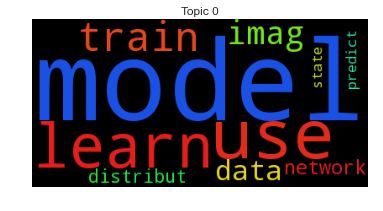

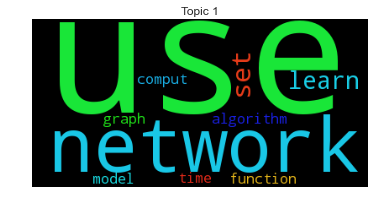

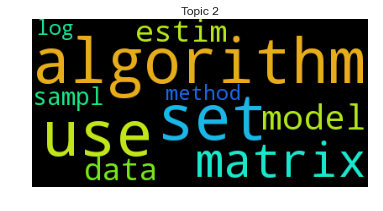

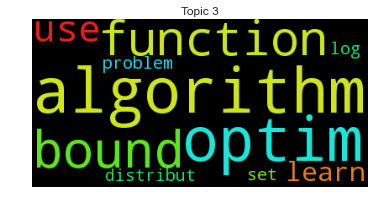

In [27]:
curr_topic = 0
for line_all in lda.show_topics():
    line = line_all[1]
    scores = [float(x.split("*")[0]) for x in line.split(" + ")]
    words = [x.split("*")[1] for x in line.split(" + ")]
    freqs = []
    for word, score in zip(words, scores):
        freqs.append((word, score))
    elements = wordcloud.WordCloud().fit_words(freqs)
    plt.figure()
    plt.title('Topic ' + str(curr_topic))
    plt.imshow(elements)
    plt.axis("off")
    curr_topic += 1

Voila! There is some pattern in these topics but I was also surpised that the word "use" was such an important word for a topic.